In [1]:
import torch 
import matplotlib.pyplot as plt
from run_model import get_dataloader
from utils import get_all_amino_acids, get_wild_type_amino_acid_sequence, count_substring_mismatch
from rnn import GenerativeRNN
from hmm import GenerativeHMM
from vae import GenerativeVAE
import numpy as np
import time
import pandas as pd
from scipy.stats import skewnorm
from utils import hmm_default_args, vae_default_args, rnn_default_args
from utils import hmm_default_small_args, vae_default_small_args, rnn_default_small_args
from utils import translate, load_data, get_all_dataset_names
from sklearn.model_selection import train_test_split
import os
import subprocess
import sys
import traceback


## Generating Random Sequences

In [2]:
def generate_mutations_df(base_sequence, mutations_lst, mutation_count_lst, alphabet, 
                          start_mutation_index=0, end_mutation_index=0, verbose=False):
    """
    Generates a mutated dataframe
    :param base_sequence: string, the sequence to be mutated
    :param mutations_lst: list, the number of mutations from the base sequence
    :param mutation_count_lst: list, defines the number of each mutation count to generate
    :param alphabet: string, the entire set of letters in the vocabulary
    :param start_mutation_index: int, how many characters to skip at the beginning of the mutation
    :param end_mutation_index: int, how many characters to skip at the end of the mutation
    :return: a dataframe comprised of three columns: the mutated strings, the number of mutations, the base_sequence
    >>> mutations_lst, base_sequence = [1, 2, 3], get_wild_type_amino_acid_sequence()
    >>> alphabet, num_per_mutation_count = get_all_amino_acids(), 100
    >>> mutated_df = generate_mutations_df(mutations_lst, base_sequence, alphabet, num_per_mutation_count, verbose=False)
    >>> for i, row in mutated_df.iterrows():
    ...     assert(count_substring_mismatch(row["mutated_string"], row["base_sequence"]) == row["mutation_count"])
    """
    start_time = time.time()
    # get index maps
    characters_to_index = dict(zip(alphabet, range(len(alphabet))))
    index_to_characters = dict(zip(range(len(alphabet)), alphabet))
    num_characters = len(alphabet)
    total_data_points = sum(mutation_count_lst)        
    mutations_per_sequence_lst = np.array([[mutation_count for _ in range(num_mutations)] 
                                for mutation_count, num_mutations in zip(mutations_lst, mutation_count_lst)]).flatten()
    assert(total_data_points < 200000)
    assert(len(mutations_lst) == len(mutation_count_lst))
    assert(len(mutations_per_sequence_lst) == total_data_points)
    mutated_strings_lst = []
    for i, mutation_count in enumerate(mutations_per_sequence_lst):
        mutated_string = get_mutation(string=base_sequence,
                                      num_mutations=mutation_count,
                                      num_characters=num_characters,
                                      characters_to_index=characters_to_index,
                                      index_to_characters=index_to_characters,
                                      start_mutation_index=start_mutation_index,
                                      end_mutation_index=end_mutation_index)
        mutated_strings_lst.append(mutated_string)
        if i % 1000 == 0 and verbose:
            print(
                "Generated {0}/{1} mutations in {2:.2f} seconds".format(i, total_data_points, time.time() - start_time))
    base_sequences_lst = [base_sequence] * total_data_points
    mutated_df = pd.DataFrame.from_dict({
        'mutated_string': mutated_strings_lst,
        'mutation_count': mutations_per_sequence_lst,
        'base_sequence': base_sequences_lst
    })
    if verbose:
        print("{0:.2f} seconds to generate the mutated df".format(time.time() - start_time))
    return mutated_df

def get_mutation(string, num_mutations, num_characters, characters_to_index, index_to_characters,
                 start_mutation_index=0, end_mutation_index=0):
    """
    get a mutation of a string
    :param string: the string to be mutated
    :param num_mutations: the number of mutations
    :param num_characters: the number of characters in alphabet
    :param characters_to_index: map from characters in alphabet to index
    :param index_to_characters: map from index in alphabet to characters
    :param start_mutation_index: how many characters to skip at the beginning of the mutation
    :param end_mutation_index: how many characters to skip at the end of the mutation
    :return: mutated string
    >>> get_mutation("AAC", num_mutations=1, num_characters=2, characters_to_index={"A": 0, "C": 1}, \
        index_to_characters={0: "A", 1: "C"}, start_mutation_index=1, end_mutation_index=1)
    'ACC'
    >>> np.random.seed(1)
    >>> get_mutation("ACTGA", num_mutations=2, num_characters=4, characters_to_index={"A": 0, "C": 1, "T": 2, "G": 3}, \
        index_to_characters={0: "A", 1: "C", 2: "T", 3: "G"}, start_mutation_index=1, end_mutation_index=1)
    'ATTAA'
    """
    mutation = list(string)
    indexes = np.random.choice(range(start_mutation_index, len(string) - end_mutation_index),
                            num_mutations, replace=False)
    for i in indexes:
        original_c = string[i]
        original_index = characters_to_index[original_c]
        # mutation by moving the character somewhere else along the possible sequences.
        new_index = (original_index + np.random.randint(1, num_characters)) % num_characters
        mutation[i] = index_to_characters[new_index]
    return "".join(mutation)

In [3]:
alphabet = get_all_amino_acids()
characters_to_index = dict(zip(alphabet, range(len(alphabet))))
index_to_characters = dict(zip(range(len(alphabet)), alphabet))

In [4]:
wild_type = get_wild_type_amino_acid_sequence()
s=get_mutation(wild_type, 238, len(alphabet), characters_to_index, index_to_characters, 0, 0)

ValueError: Cannot take a larger sample than population when 'replace=False'

In [115]:
print("Mismatches:", count_substring_mismatch(s, wild_type))
print(s)

Mismatches: 238
AFRLANQFAAAITPLFPI*LWKEVRPFGCLWKD*GQNSAMNPGHNEIQWAVKGNLADNIFRVGPVRMPESQMVNKVGGRSRGPHQDAGNPECWSYFP*YYFP*SRWFDG*CNRRKHKIQRQWVVASD*MFSVTAAMKMFGTC*VRK*CPIWDDLYFMWFWFDMVT**KFNACMFDSQPVTWLHKQDSHITQYTMCWARSKGWRFGRETTKQSHEMEYEPSFHTLMIKACVVN*DPWPK


In [124]:
mutations_lst = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mutations_count = [100] * 10
base_sequence = wild_type
alphabet = get_all_amino_acids() 
num_per_mutation_count = 1000
start_mutation_index = 5
end_mutation_index = 5
mutated_df = generate_mutations_df(base_sequence, mutations_lst, mutations_count, alphabet, start_mutation_index, end_mutation_index, verbose=True)

Generated 0/1000 mutations in 0.00 seconds
0.13 seconds to generate the mutated df


In [127]:
for i, row in mutated_df.iterrows():
    assert(count_substring_mismatch(row["mutated_string"], row["base_sequence"]) == row["mutation_count"])
    assert(count_substring_mismatch(row["mutated_string"][:start_mutation_index], row["base_sequence"][:start_mutation_index]) == 0)
    assert(count_substring_mismatch(row["mutated_string"][-end_mutation_index:], row["base_sequence"][-end_mutation_index:]) == 0)

In [126]:
print(mutated_df.shape)

(1000, 3)


In [129]:
from sklearn.model_selection import train_test_split

mutations_lst = range(10)
mutations_count = [1000] * 10
name = "synthetic_data_length_20_uniform"
base_sequence = "GYSSASKIIFGSGTRLSIRP"
alphabet = get_all_amino_acids()
start_mutation_index = 1
end_mutation_index = 1
mutated_df = generate_mutations_df(base_sequence, mutations_lst, mutations_count, alphabet,
                                   start_mutation_index, end_mutation_index, verbose=True)
mutated_df = mutated_df.sample(frac=1).reset_index(drop=True)
mutated_df.to_csv(name + ".csv")
x_train, x_test = train_test_split(mutated_df, test_size = 0.5)

Generated 0/10000 mutations in 0.00 seconds
Generated 1000/10000 mutations in 0.08 seconds
Generated 2000/10000 mutations in 0.14 seconds
Generated 3000/10000 mutations in 0.20 seconds
Generated 4000/10000 mutations in 0.26 seconds
Generated 5000/10000 mutations in 0.33 seconds
Generated 6000/10000 mutations in 0.39 seconds
Generated 7000/10000 mutations in 0.45 seconds
Generated 8000/10000 mutations in 0.54 seconds
Generated 9000/10000 mutations in 0.62 seconds
0.69 seconds to generate the mutated df


In [132]:
np.save(name + "_x_train.npy", x_train)
np.save(name + "_x_test.npy", x_test)

## Discrete Gaussian Distributions

In [262]:
def generate_discrete_gaussian_distribution(num_values, mean=5.5, std=2, low=1, high=10):
    """
    generates a discrete gaussian distribution
    :param num_values: int, number of samples to take from discrete distribution
    :param mean: float, mean of gaussian
    :param std: float, standard deviation of gaussian
    :param low: int, lowest value the discrete distribution will have
    :param high: int, highest value the discrete distribution will have
    :return: gaussian_lst, list, list of values in distributions
            bins, dict, map between the values and counts in distribution
    >>> np.random.seed(1)
    >>> generate_discrete_gaussian_distribution(10, 0, 1, -4, 4)[0]
    [2.0, -1.0, -1.0, -1.0, 1.0, -2.0, 2.0, -1.0, 0.0, -0.0]
    >>> generate_discrete_gaussian_distribution(10, 0, 1, -4, 4)[1]
    {-4: 0.0, -3: 0.0, -2: 1.0, -1: 2.0, 0: 4.0, 1: 3.0, 2: 0.0, 3: 0.0, 4: 0.0}
    """
    normal_lst = np.random.normal(loc=mean, scale=std, size=num_values)
    bins = dict(zip(list(range(low, high + 1)), np.zeros(high - low + 1)))
    gaussian_lst = []
    for x in normal_lst:
        if x <= low:
            gaussian_lst.append(low)
            bins[low] += 1
        elif x >= high:
            gaussian_lst.append(high)
            bins[high] += 1
        else:
            gaussian_lst.append(round(x))
            bins[round(x)] += 1
    return gaussian_lst, bins

{1: 246.0, 2: 426.0, 3: 848.0, 4: 1465.0, 5: 1973.0, 6: 1935.0, 7: 1537.0, 8: 888.0, 9: 453.0, 10: 229.0}


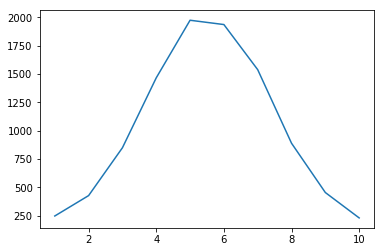

In [266]:
hist = generate_discrete_gaussian_distribution(10000, 5.5, 2, 1, 10)[1]
print(hist)
plt.plot(hist.keys(), hist.values())

In [270]:
def generate_discrete_skewed_gaussian_distribution(num_values, a=4, mean=5.5, std=2, low=1, high=10):
    """
    generates a discrete skewed gaussian distribution
    :param num_values: int, number of samples to take from discrete distribution
    :param a: float, skew of the distribution, positive is right leaning, negative is left learning
    :param mean: float, mean of gaussian
    :param std: int, standard deviation of gaussian
    :param low: int, lowest value the discrete distribution will have
    :param high: int, highest value the discrete distribution will have
    :return: skewed_gaussian_lst, list, list of values in distributions
            bins, dict, map between the values and counts in distribution
    >>> np.random.seed(1)
    >>> generate_discrete_skewed_gaussian_distribution(num_values=10, a=4, mean=0, std=1, low=-4, high=4)[0]
    [2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0]
    >>> generate_discrete_skewed_gaussian_distribution(num_values=10, a=4, mean=0, std=1, low=-4, high=4)[1]
    {-4: 0.0, -3: 0.0, -2: 0.0, -1: 0.0, 0: 3.0, 1: 7.0, 2: 0.0, 3: 0.0, 4: 0.0}
    """
    skewed_lst = skewnorm(a=a, loc=mean, scale=std).rvs(num_values)
    bins = dict(zip(list(range(low, high + 1)), np.zeros(high - low + 1)))
    skewed_gaussian_lst = []
    for x in skewed_lst:
        if x <= low:
            skewed_gaussian_lst.append(low)
            bins[low] += 1
        elif x >= high:
            skewed_gaussian_lst.append(high)
            bins[high] += 1
        else:
            skewed_gaussian_lst.append(round(x))
            bins[round(x)] += 1
    return skewed_gaussian_lst, bins

{1: 5.0, 2: 342.0, 3: 2028.0, 4: 3065.0, 5: 2418.0, 6: 1366.0, 7: 545.0, 8: 181.0, 9: 39.0, 10: 11.0}


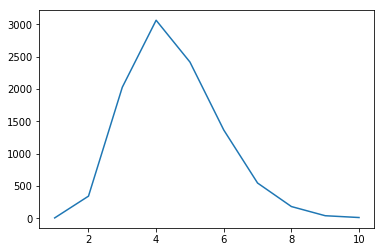

In [271]:
hist = generate_discrete_skewed_gaussian_distribution(10000, 3, 3, 2, 1, 10)[1]
print(hist)
plt.plot(hist.keys(), hist.values())

In [294]:
def generate_discrete_uniform_distribution(num_values, low=1, high=10):
    """
    generates a discrete uniform distribution
    :param num_values: int, number of samples to take from discrete distribution
    :param low: int, lowest value the discrete distribution will have
    :param high: int, highest value the discrete distribution will have
    :return: uniform_lst, list, list of values in distribution
            bins, dict, map between the values and counts in distribution
    >>> generate_discrete_uniform_distribution(num_values=10, low=1, high=10)[0]
    [2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 0.0, 0.0]
    >>> generate_discrete_uniform_distribution(num_values=10, low=1, high=10)[1]
    {-4: 0.0, -3: 0.0, -2: 0.0, -1: 0.0, 0: 3.0, 1: 7.0, 2: 0.0, 3: 0.0, 4: 0.0}
    """
    uniform_lst = np.random.choice(range(low, high + 1), num_values, replace=True)
    bins = dict(zip(list(range(low, high + 1)), np.zeros(high - low + 1)))
    for x in uniform_lst: 
        bins[x] += 1
    return uniform_lst, bins

{1: 1033.0, 2: 1006.0, 3: 988.0, 4: 1015.0, 5: 1008.0, 6: 955.0, 7: 970.0, 8: 1032.0, 9: 984.0, 10: 1009.0}


([<matplotlib.axis.YTick at 0x111a1c438>,
 <a list of 10 Text yticklabel objects>)

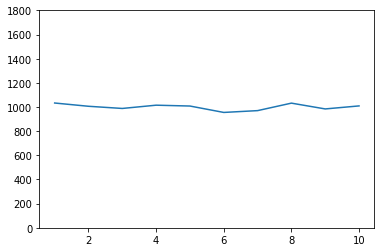

In [303]:
hist = generate_discrete_uniform_distribution(10000, 1, 10)[1]
print(hist)
plt.plot(hist.keys(), hist.values())
plt.yticks(list(range(0, 2000, 200)))

In [286]:
np.digitize([1, 2, 2, 2, 1, 2, 3, 4, 5], bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

array([1, 2, 2, 2, 1, 2, 3, 4, 5])

## Script Commands

In [34]:
for mp in [hmm_default_args(), rnn_default_args(), vae_default_args()]:
    command = "python3 run_model.py "
    for key, value in mp.items():
        command += "--{0} {1} ".format(key, value)
    print("#", mp["name"])
    print(command)

# hmm_default_medium
python3 run_model.py --model_type hmm --base_log logs/gfp/hmm/ --name hmm_default_medium --input 4998 --hidden_size 50 --latent_dim -1 --seq_length 238 --pseudo_count 1 --n_jobs 1 --device cpu --learning_rate 0.001 --epochs 100 --batch_size 10 --layers 1 --dataset gfp --num_data 1000 --early_stopping True --patience 10 
# rnn_default_medium
python3 run_model.py --model_type rnn --base_log logs/gfp/rnn/ --name rnn_default_medium --input 4998 --hidden_size 200 --latent_dim -1 --seq_length 238 --pseudo_count 1 --n_jobs 1 --device cpu --learning_rate 0.001 --epochs 100 --batch_size 10 --layers 1 --dataset gfp --num_data 1000 --early_stopping True --patience 10 
# vae_default_medium
python3 run_model.py --model_type vae --base_log logs/gfp/vae/ --name vae_default_medium --input 4998 --hidden_size 200 --latent_dim 20 --seq_length 238 --pseudo_count 1 --n_jobs 1 --device cpu --learning_rate 0.001 --epochs 100 --batch_size 10 --layers 1 --dataset gfp --num_data 1000 --earl

In [35]:
for mp in [hmm_default_small_args(), rnn_default_small_args(), vae_default_small_args()]:
    command = "python3 run_model.py "
    for key, value in mp.items():
        command += "--{0} {1} ".format(key, value)
    print("#", mp["name"])
    print(command)

# hmm_default_small
python3 run_model.py --model_type hmm --base_log logs/gfp/hmm/ --name hmm_default_small --input 4998 --hidden_size 20 --latent_dim -1 --seq_length 238 --pseudo_count 1 --n_jobs 1 --device cpu --learning_rate 0.001 --epochs 10 --batch_size 10 --layers 1 --dataset gfp --num_data 100 --early_stopping True --patience 10 
# rnn_default_small
python3 run_model.py --model_type rnn --base_log logs/gfp/rnn/ --name rnn_default_small --input 4998 --hidden_size 50 --latent_dim -1 --seq_length 238 --pseudo_count 1 --n_jobs 1 --device cpu --learning_rate 0.001 --epochs 10 --batch_size 10 --layers 1 --dataset gfp --num_data 100 --early_stopping True --patience 10 
# vae_default_small
python3 run_model.py --model_type vae --base_log logs/gfp/vae/ --name vae_default_small --input 4998 --hidden_size 50 --latent_dim 20 --seq_length 238 --pseudo_count 1 --n_jobs 1 --device cpu --learning_rate 0.001 --epochs 10 --batch_size 10 --layers 1 --dataset gfp --num_data 100 --early_stopping Tru

In [30]:
logger=open("./scripts/synthetic_unimodal_small_script.sh", "w")
num_commands = 0
for mp in [vae_default_small_args(), rnn_default_small_args(), hmm_default_small_args()]:
    for i, data_set_description in pd.read_csv("./data/dataset_descriptions.csv").iterrows():
        if "unimodal" not in data_set_description["dataset"]:
            continue
        command = "python3 run_model.py "
        mp["dataset"] = data_set_description["dataset"]
        mp["base_log"] = os.path.join("logs", mp["dataset"], mp["model_type"])
        mp["seq_length"] = data_set_description["sequence_length"]
        mp["input"] = len(get_all_amino_acids(gap=False)) * mp["seq_length"]
        for key, value in mp.items():
            command += "--{0} {1} ".format(key, value)
        print(command, file=logger)
        num_commands += 1
assert(num_commands == 27)
logger.close()
# python3 run_model.py --model_type vae --base_log logs/synthetic_unimodal_data_length_20_uniform/vae/ --name vae_default_small --input 400 --hidden_size 50 --latent_dim 20 --seq_length 20 --pseudo_count 1 --n_jobs 1 --device cpu --learning_rate 0.001 --epochs 100 --batch_size 10 --layers 1 --dataset synthetic_unimodal_data_length_20_uniform --num_data 1000

In [31]:
logger=open("./scripts/synthetic_unimodal_medium_script.sh", "w")
num_commands = 0
for mp in [vae_default_args(), rnn_default_args(), hmm_default_args()]:
    for i, data_set_description in pd.read_csv("./data/dataset_descriptions.csv").iterrows():
        if "unimodal" not in data_set_description["dataset"]:
            continue
        command = "python3 run_model.py "
        mp["dataset"] = data_set_description["dataset"]
        mp["base_log"] = os.path.join("logs", mp["dataset"], mp["model_type"])
        mp["seq_length"] = data_set_description["sequence_length"]
        mp["input"] = len(get_all_amino_acids(gap=False)) * mp["seq_length"]
        for key, value in mp.items():
            command += "--{0} {1} ".format(key, value)
        print(command, file=logger)
        num_commands += 1
assert(num_commands == 27)
logger.close()
# python3 run_model.py --model_type vae --base_log logs/synthetic_unimodal_data_length_20_uniform/vae/ --name vae_default_small --input 400 --hidden_size 50 --latent_dim 20 --seq_length 20 --pseudo_count 1 --n_jobs 1 --device cpu --learning_rate 0.001 --epochs 100 --batch_size 10 --layers 1 --dataset synthetic_unimodal_data_length_20_uniform --num_data 1000

In [8]:
num_commands = 0
for mp in [vae_default_small_args(), rnn_default_small_args(), hmm_default_small_args()]:
    logger=open("./scripts/{0}_unimodal_small_script.sh".format(mp["model_type"]), "w+")
    for i, data_set_description in pd.read_csv("./data/dataset_descriptions.csv").iterrows():
        if "unimodal" not in data_set_description["dataset"]:
            continue
        command = "python3 run_model.py "
        mp["dataset"] = data_set_description["dataset"]
        mp["base_log"] = os.path.join("logs", mp["dataset"], mp["model_type"])
        mp["seq_length"] = data_set_description["sequence_length"]
        mp["input"] = len(get_all_amino_acids(gap=False)) * mp["seq_length"]
        for key, value in mp.items():
            command += "--{0} {1} ".format(key, value)
        print(command, file=logger)
        num_commands += 1
    logger.close()
assert(num_commands == 27)
# python3 run_model.py --model_type vae --base_log logs/synthetic_unimodal_data_length_20_uniform/vae/ --name vae_default_small --input 400 --hidden_size 50 --latent_dim 20 --seq_length 20 --pseudo_count 1 --n_jobs 1 --device cpu --learning_rate 0.001 --epochs 100 --batch_size 10 --layers 1 --dataset synthetic_unimodal_data_length_20_uniform --num_data 1000

In [32]:
logger = open("./scripts/synthetic_multimodal_medium_script.sh", "w")
num_commands = 0
for mp in [vae_default_args(), rnn_default_args(), hmm_default_args()]:
    for i, data_set_description in pd.read_csv("./data/dataset_descriptions.csv").iterrows():
        if "multimodal" not in data_set_description["dataset"]:
            continue
        command = "python3 run_model.py "
        mp["dataset"] = data_set_description["dataset"]
        mp["base_log"] = os.path.join("logs", mp["dataset"], mp["model_type"])
        mp["seq_length"] = data_set_description["sequence_length"]
        mp["input"] = len(get_all_amino_acids(gap=False)) * mp["seq_length"]
        for key, value in mp.items():
            command += "--{0} {1} ".format(key, value)
        print(command, file=logger)
        num_commands += 1
assert(num_commands == 9)
logger.close()
# python3 run_model.py --model_type vae --base_log logs/synthetic_unimodal_data_length_20_uniform/vae/ --name vae_default_small --input 400 --hidden_size 50 --latent_dim 20 --seq_length 20 --pseudo_count 1 --n_jobs 1 --device cpu --learning_rate 0.001 --epochs 100 --batch_size 10 --layers 1 --dataset synthetic_unimodal_data_length_20_uniform --num_data 1000

In [33]:
logger = open("./scripts/synthetic_multimodal_small_script.sh", "w")
num_commands = 0
for i, data_set_description in pd.read_csv("./data/dataset_descriptions.csv").iterrows():
    for mp in [vae_default_small_args(), rnn_default_small_args(), hmm_default_small_args()]:
        if "multimodal" not in data_set_description["dataset"]:
            continue
        command = "python3 run_model.py "
        mp["dataset"] = data_set_description["dataset"]
        mp["base_log"] = os.path.join("logs", mp["dataset"], mp["model_type"])
        mp["seq_length"] = data_set_description["sequence_length"]
        mp["input"] = len(get_all_amino_acids(gap=False)) * mp["seq_length"]
        for key, value in mp.items():
            command += "--{0} {1} ".format(key, value)
        print(command, file=logger)
        num_commands += 1
assert(num_commands == 9)
logger.close()
# python3 run_model.py --model_type vae --base_log logs/synthetic_unimodal_data_length_20_uniform/vae/ --name vae_default_small --input 400 --hidden_size 50 --latent_dim 20 --seq_length 20 --pseudo_count 1 --n_jobs 1 --device cpu --learning_rate 0.001 --epochs 100 --batch_size 10 --layers 1 --dataset synthetic_unimodal_data_length_20_uniform --num_data 1000

## Load Model Tests and Examples

In [49]:
args = hmm_default_small_args()
train, test, valid = get_dataloader(args)
hmm = GenerativeHMM(args)

In [50]:
hmm.load_model("./logs/gfp/hmm/hmm_default_small/hmm_default_small_saved_model")

In [51]:
hmm.evaluate(dataloader=train, verbose=True)
hmm.evaluate(dataloader=valid, verbose=True)
hmm.evaluate(dataloader=test, verbose=True)

Average neg log prob: 643.8108
Average neg log prob: 644.5363
Average neg log prob: 644.3261


644.3261382530319

In [52]:
args = rnn_default_small_args()
train, test, valid = get_dataloader(args)
rnn = GenerativeRNN(args)
rnn.load_model("./logs/gfp/rnn/rnn_default_small/rnn_default_small_saved_model", initial_probs=True)
rnn.evaluate(dataloader=train, verbose=True)
rnn.evaluate(dataloader=valid, verbose=True)
rnn.evaluate(dataloader=test, verbose=True)

total loss: 141.1837
total loss: 147.8163
total loss: 146.6423


146.64228515625

In [53]:
args = vae_default_small_args()
train, test, valid = get_dataloader(args)
vae = GenerativeVAE(args)
vae.load_model("./logs/gfp/vae/vae_default_small/vae_default_small_saved_model", initial_probs=True)
vae.evaluate(dataloader=train, verbose=True)
vae.evaluate(dataloader=valid, verbose=True)
vae.evaluate(dataloader=test, verbose=True)

total loss: 45.6191 cross entropy loss: 30.0420. kld loss: 15.5770
total loss: 48.6362 cross entropy loss: 33.0811. kld loss: 15.5551
total loss: 48.0014 cross entropy loss: 32.4644. kld loss: 15.5370


(48.001426696777344, 32.464420318603516, 15.537006378173828)

In [54]:
args = vae_default_args()
train, test, valid = get_dataloader(args)
vae = GenerativeVAE(args)
vae.load_model("./logs/gfp/vae/vae_default_medium/vae_default_medium_saved_model")
vae.evaluate(dataloader=train, verbose=True)
vae.evaluate(dataloader=valid, verbose=True)
vae.evaluate(dataloader=test, verbose=True)
vae.load_model("./logs/gfp/vae/vae_default_medium/vae_checkpoint_50.pt")
vae.evaluate(dataloader=train, verbose=True)
vae.evaluate(dataloader=valid, verbose=True)
vae.evaluate(dataloader=test, verbose=True)
vae.load_model("./logs/gfp/vae/vae_default_medium/vae_checkpoint_100.pt")
vae.evaluate(dataloader=train, verbose=True)
vae.evaluate(dataloader=valid, verbose=True)
vae.evaluate(dataloader=test, verbose=True)

total loss: 32.8738 cross entropy loss: 26.6793. kld loss: 6.1945
total loss: 33.3337 cross entropy loss: 27.1171. kld loss: 6.2166
total loss: 32.7038 cross entropy loss: 26.5114. kld loss: 6.1924
total loss: 28.3956 cross entropy loss: 25.3037. kld loss: 3.0919
total loss: 28.4135 cross entropy loss: 25.2355. kld loss: 3.1780
total loss: 28.0267 cross entropy loss: 24.8950. kld loss: 3.1317
total loss: 32.7605 cross entropy loss: 26.5660. kld loss: 6.1945
total loss: 32.9785 cross entropy loss: 26.7619. kld loss: 6.2166
total loss: 32.5586 cross entropy loss: 26.3662. kld loss: 6.1924


(32.55861282348633, 26.366209030151367, 6.1924028396606445)

## GFP Data checks

In [2]:
df = pd.read_csv("./data/gfp_data.csv")

In [3]:
wild_type = df["nucSequence"].values[0]
aa_wild_type = translate(df["nucSequence"].values[0])
assert(all([count_substring_mismatch(x1, wild_type) == x2 for x1, x2 in zip(df["nucSequence"].values, df["numNucMutations"])]))

In [4]:
df = df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1'], axis = 1)

In [5]:
df.columns

Index(['nucSequence', 'numNucMutations', 'numAAMutations', 'uniqueBarcodes',
       'medianBrightness', 'std', 'aaSequence'],
      dtype='object')

In [6]:
df["aaSequence"] = df["nucSequence"].apply(lambda x : translate(x))

In [7]:
print(len(wild_type)), print(len(aa_wild_type)), print(len(df["aaSequence"][0]))

714
238
238


(None, None, None)

In [8]:
for x1, x2 in zip(df["aaSequence"].values, df["numAAMutations"].values):
    assert(count_substring_mismatch(x1, aa_wild_type) == x2)
    assert("*" in x1)

In [9]:
df = df.sample(frac=1).reset_index(drop=True)
df["aaSequence"] = df["aaSequence"].apply(lambda x : x.upper())
train_size = int(df.shape[0] * 0.8)
train_df = df[:train_size].reset_index(drop=True)
assert(wild_type in train_df["nucSequence"].values)
test_df = df[train_size: ].reset_index(drop=True)
print(train_df.shape, test_df.shape)

(46733, 7) (11684, 7)


In [10]:
df.head(10), df.shape, train_df.head(10), train_df.shape, test_df.head(10), test_df.shape

(                                         nucSequence  numNucMutations  \
 0  AGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGACG...                6   
 1  AGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCG...                2   
 2  AGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCG...                5   
 3  AGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCG...                4   
 4  AGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCG...                3   
 5  AGCAAGGGCGAGGAGCTGTTCTCCGGGGTGGTGCCCATCCTGGTCG...                5   
 6  AGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCG...                2   
 7  AGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCG...                5   
 8  AGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTTCCCATCCTGGTCG...                3   
 9  AGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCG...                2   
 
    numAAMutations  uniqueBarcodes  medianBrightness  std  \
 0               6               1          1.303274  0.0   
 1               1               1          3.807237  0.0   
 

In [11]:
train_df.to_csv("./data/gfp_train.csv", index=False)
test_df.to_csv("./data/gfp_test.csv", index=False)

In [13]:
np.save("./data/gfp_x_train.npy", train_df["aaSequence"].values)
np.save("./data/gfp_x_test.npy", test_df["aaSequence"].values)
np.save("./data/gfp_y_train.npy", train_df["medianBrightness"].values)
np.save("./data/gfp_y_test.npy", test_df["medianBrightness"].values)

In [14]:
x_train, x_test, y_train, y_test = load_data("./data/gfp_")

In [15]:
list(map(len, [x_train, x_test, y_train, y_test]))

[46733, 11684, 46733, 11684]

(array([4.0140e+03, 1.0766e+04, 1.8015e+04, 5.7710e+03, 5.9220e+03,
        1.2210e+03, 8.4700e+02, 1.1400e+02, 5.7000e+01, 6.0000e+00]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

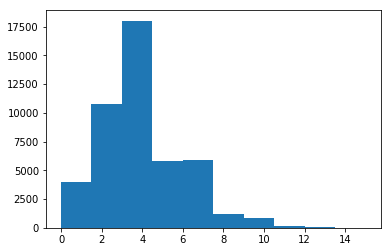

In [22]:
plt.hist([count_substring_mismatch(x1, aa_wild_type) for x1 in x_train])

(array([9.880e+02, 2.745e+03, 4.431e+03, 1.444e+03, 1.504e+03, 3.050e+02,
        2.190e+02, 2.800e+01, 1.800e+01, 2.000e+00]),
 array([ 0. ,  1.5,  3. ,  4.5,  6. ,  7.5,  9. , 10.5, 12. , 13.5, 15. ]),
 <a list of 10 Patch objects>)

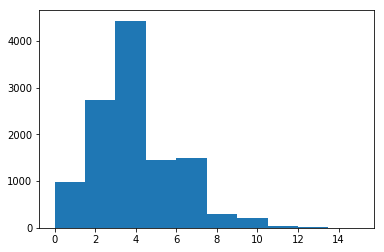

In [23]:
plt.hist([count_substring_mismatch(x1, aa_wild_type) for x1 in x_test])

In [21]:
y_train.shape

(46733,)

In [18]:
len(x_train[0])

238

## Refresh python syntax in kwargs and class inheritance


In [134]:
def greet_me(**kwargs):
    if kwargs is not None:
        for key, value in kwargs.items():
            print("%s == %s" % (key,value))

In [142]:
def pass_kwargs(x = 3, **kwargs):
    greet_me(**kwargs)

In [141]:
d = {"tmp":2, "math":4}
pass_kwargs(x = 3, **d)

{'tmp': 2, 'math': 4}
tmp == 2
math == 4


In [139]:
class S: 
    def print_hello(self):
        print("hello")
        
class B(S): 
    def print_goodbye(self): 
        super().print_hello()
        print('goodbye')

In [140]:
B().print_goodbye()

hello
goodbye


## Print Out Previous Experiment Results

In [6]:
def run_bash(cmd, queue=None):
    p = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, executable='/bin/bash')
    std_out = p.stdout.read().strip()
    if p.stderr:
        std_err = p.stderr.read().strip()
    else:
        std_err = None
    if queue is not None:
        queue.put(std_out)
    return std_out, std_err  # This is the stdout from the shell command

std_out_lst, std_err_lst = [], []
for i in range(0, 27):
    std_out, std_err = run_bash("ts -i {0}".format(i))
    std_out = std_out.decode('utf-8') if std_out else None
    std_err = std_err.decode('utf-8') if std_err else None
    std_out_lst.append(std_out)
    std_err_lst.append(std_err)


In [28]:
for i, (std_out, std_err) in enumerate(zip(std_out_lst, std_err_lst)):
    print("Trial {0} Standard out:".format(i))
    print("-" * 50)
    print(std_out)
    print("-" * 50)
    print("Trial {0} Standard err:".format(i))
    print("-" * 50)
    print(std_err)
    print("=" * 50)

Trial 0 Standard out:
--------------------------------------------------
Exit status: died with exit code 0
Command: bash -c python3 run_model.py --model_type hmm --base_log logs/synthetic_unimodal_data_length_100_gaussian/hmm --name hmm_default_small --input 2000 --hidden_size 30 --latent_dim -1 --seq_length 100 --pseudo_count 1 --n_jobs 1 --device cpu --learning_rate 0.001 --epochs 10 --batch_size 10 --layers 1 --dataset synthetic_unimodal_data_length_100_gaussian --num_data 100
Slots required: 1
Enqueue time: Thu May  9 03:34:09 2019
Start time: Thu May  9 03:34:09 2019
End time: Thu May  9 03:35:59 2019
Time run: 110.697662s
--------------------------------------------------
Trial 0 Standard err:
--------------------------------------------------
None
Trial 1 Standard out:
--------------------------------------------------
Exit status: died with exit code 0
Command: bash -c python3 run_model.py --model_type rnn --base_log logs/synthetic_unimodal_data_length_100_gaussian/rnn --name 

## mutation counts of datasets

In [20]:
for dataset in os.listdir("./data/"): 
    if ".csv" in dataset: 
        df = pd.read_csv("./data/" + dataset)
        if "mutation_count" not in df.columns:
            continue
        print("dataset: {0}, average mutation count: {1}".format(dataset, np.mean(df["mutation_count"].values)))

dataset: synthetic_multimodal_data_modes_2_length_51_uniform.csv, average mutation count: 5.5
dataset: synthetic_multimodal_data_modes_3_length_51_uniform.csv, average mutation count: 5.5
dataset: synthetic_multimodal_data_modes_5_length_51_uniform.csv, average mutation count: 5.5
dataset: synthetic_mutations_21_unimodal_data_length_100_uniform.csv, average mutation count: 11.0089
dataset: synthetic_mutations_21_unimodal_data_length_50_uniform.csv, average mutation count: 11.0089
dataset: synthetic_unimodal_data_length_100_gaussian.csv, average mutation count: 5.5079
dataset: synthetic_unimodal_data_length_100_skewed_gaussian.csv, average mutation count: 5.05046
dataset: synthetic_unimodal_data_length_100_uniform.csv, average mutation count: 5.51174
dataset: synthetic_unimodal_data_length_20_gaussian.csv, average mutation count: 5.5079
dataset: synthetic_unimodal_data_length_20_skewed_gaussian.csv, average mutation count: 5.05046
dataset: synthetic_unimodal_data_length_20_uniform.csv, 

In [23]:
print('dataset: gfp, average mutation count: {0}'.format(pd.read_csv("./data/gfp_data.csv")["numAAMutations"].mean()))

dataset: gfp, average mutation count: 3.7105123508567712


## Check all 27 files



In [11]:
for dirpath, dirnames, filenames in os.walk("./logs/"):
    print(dirpath)
    if not dirnames:
        for file in filenames: 
            file_name = os.path.join(dirpath, file)
            if "log.txt" in file_name: 
                run_bash("open {0}".format(file_name))
        try:
            x = input("Press enter to continue")
        except SyntaxError:
            pass

./logs/
./logs/gfp
./logs/gfp/hmm
./logs/gfp/hmm/hmm_default_medium
Press enter to continue
./logs/gfp/hmm/hmm_default_small
Press enter to continue
./logs/gfp/rnn
./logs/gfp/rnn/rnn_default_medium
Press enter to continue
./logs/gfp/rnn/rnn_default_small
Press enter to continue
./logs/gfp/vae
./logs/gfp/vae/vae_default_large
Press enter to continue
./logs/gfp/vae/vae_default_medium
Press enter to continue
./logs/gfp/vae/vae_default_small
Press enter to continue
./logs/synthetic_multimodal_data_modes_2_length_51_uniform
./logs/synthetic_multimodal_data_modes_2_length_51_uniform/hmm
./logs/synthetic_multimodal_data_modes_2_length_51_uniform/hmm/hmm_default_medium
Press enter to continue
./logs/synthetic_multimodal_data_modes_2_length_51_uniform/hmm/hmm_default_small
Press enter to continue
./logs/synthetic_multimodal_data_modes_2_length_51_uniform/rnn
./logs/synthetic_multimodal_data_modes_2_length_51_uniform/rnn/rnn_default_medium
Press enter to continue
./logs/synthetic_multimodal_data

KeyboardInterrupt: 

## try catch block

In [135]:
x = False
try: 
    pd.read_csv("./a")
except Exception as e:
    logger = open("./tmp.txt", "w+")
    exc_type, exc_value, exc_traceback = sys.exc_info()
    print("=" * 50, file=logger)
    print("Error in running experiment: {0}\nTraceback log: ".format("1"), file=logger)
    print("=" * 50, file=logger)
    traceback.print_tb(exc_traceback, file=logger)
    x = True
finally:
    print(1)
    if logger:
        logger.close()
    if x: 
        raise exc_value
    else: 
        print(1)

1


FileNotFoundError: File b'./a' does not exist

In [128]:
!open tmp.txt

In [112]:
!rm tmp.txt

In [144]:
try: 
    for i in range(10000000000): 
        if i % 10000000 == 0: 
            print(i)
except: 
    print("python")

0
10000000
20000000
30000000
python


In [145]:
# these two are different 
try: 
    for i in range(10000000000): 
        if i % 10000000 == 0: 
            print(i)
except Exception as e: 
    print("python") 

0
10000000
20000000


KeyboardInterrupt: 